In [1]:
library(tidyverse)
library(taxize)
library(ggtree)
library(arcadiathemeR)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggtree v3.10.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and 

All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [2]:
setwd("..")

In [3]:
# Sample dataframe with NCBI taxonomy IDs and metadata
df <- read_tsv("inputs/2024_mimics_uniprot_reference_proteomes_human_long_association.tsv", show_col_types = FALSE)
count_df <- read_tsv("num_eukaryote_matches.tsv", show_col_types = FALSE) 
df <- left_join(df, count_df, by = c("organism" = "query_organism")) %>%
  replace_na(list(num_matches = 0))

In [4]:
# Get taxonomic classifications
classifications <- classification(df$organism_id, db = "ncbi")

In [5]:
# Build a tree from classifications
tree_data <- class2tree(classifications)

Get all ranks and their taxIDs

Align taxonomy hierarchies...

Taxonomy alignment done!

Calculate distance matrix

Add node labels



In [6]:
# Extract species names
species_names <- sapply(classifications, function(x) {
  x$name[x$rank == "species"]
})

In [7]:
# Specify the taxonomic rank to color by (e.g., "phylum" or "family")
taxonomic_rank_tmp <- "phylum"

# Extract the specified taxonomic rank for each species
taxonomic_rank_names <- sapply(classifications, function(x) {
  rank_name <- x$name[x$rank == taxonomic_rank_tmp]
  if (length(rank_name) == 0) NA else rank_name
})

In [8]:
# Create a data frame mapping taxid to species name
taxid_species <- data.frame(organism_id = as.numeric(names(classifications)), 
                            species = species_names,
                            taxonomic_rank = taxonomic_rank_names,
                            stringsAsFactors = FALSE)

In [9]:
# Merge species names with original dataframe
df <- df %>%
  left_join(taxid_species, by = "organism_id")

In [10]:
df <- df %>%
  mutate(species = str_remove(string = organism, pattern = " \\(.*"),
         species = ifelse(species == "Plasmodium vivax", "Plasmodium vivax Sal-1", species),
         species = ifelse(species == "Trypanosoma cruzi", "Trypanosoma cruzi strain CL Brener", species),
         species = ifelse(species == "Pediculus humanus subsp. corporis", "Pediculus humanus corporis", species),
         species = ifelse(species == "Plasmodium falciparum", "Plasmodium falciparum 3D7", species),
         species = ifelse(species == "Babesia microti", "Babesia microti strain RI", species),
         species = ifelse(species == "Cryptosporidium parvum", "Cryptosporidium parvum Iowa II", species),
         species = ifelse(species == "Toxoplasma gondii", "Toxoplasma gondii VEG", species)) 

In [23]:
rownames(df) <- df$species

Warning message:
“Setting row names on a tibble is deprecated.”


In [27]:
rownames(df)

[1] "Bodo saltans"                       "Leishmania infantum"               
 [3] "Leishmania major"                   "Leishmania braziliensis"           
 [5] "Trypanosoma cruzi strain CL Brener" "Ancylostoma ceylanicum"            
 [7] "Necator americanus"                 "Toxocara canis"                    
 [9] "Dracunculus medinensis"             "Enterobius vermicularis"           
[11] "Brugia malayi"                      "Onchocerca volvulus"               
[13] "Wuchereria bancrofti"               "Acrobeloides nanus"                
[15] "Sarcoptes scabiei"                  "Ixodes scapularis"                 
[17] "Pediculus humanus corporis"         "Macrostomum lignano"               
[19] "Opisthorchis felineus"              "Schistosoma haematobium"           
[21] "Schistosoma mansoni"                "Plasmodium falciparum 3D7"         
[23] "Plasmodium malariae"                "Plasmodium ovale"                  
[25] "Plasmodium vivax Sal-1"             "Babesia microti strain RI"         
[27] "Cryptosporidium parvum Iowa II"     "Cyclospora cayetanensis"           
[29] "Toxoplasma gondii VEG"

## Deal with tissue tropism formatting

In [11]:
df <- df %>%
  mutate(tissue_tropism = replace_na(tissue_tropism, ""),
         tissue_tropism = str_replace_all(tissue_tropism, ",", ";"))

In [12]:
tissue_list <- strsplit(df$tissue_tropism, split = ";\\s*")

# Create a list of all unique tissues
all_tissues <- unique(unlist(tissue_list))
all_tissues <- all_tissues[all_tissues != ""]

In [13]:
# Create a presence-absence matrix
tissue_matrix <- sapply(all_tissues, function(tissue) {
  sapply(tissue_list, function(tissues) {
    if (length(tissues) == 0) {
      0  # No tissues listed
    } else if (tissue %in% tissues) {
      1  # Tissue is present
    } else {
      0  # Tissue is absent
    }
  })
})

In [14]:
# Convert to a data frame and add species names
tissue_df <- as.data.frame(tissue_matrix)
tissue_df$species <- df$species

In [49]:
# Create a data frame for the tip labels
tip_data <- data.frame(
  label = tree_data$phylo$tip.label,
  stringsAsFactors = FALSE
)

In [50]:
# Merge tip labels with metadata
tip_data <- tip_data %>%
  left_join(df, by = c("label" = "species")) %>%
  left_join(tissue_df, by = c("label" = "species"))

In [17]:
heatmap_data <- tip_data %>%
  select(any_of(colnames(tissue_df)), label) %>%
  column_to_rownames("label") %>%
  mutate_all(as.factor)

In [32]:
rownames(tip_data) <- tip_data$label

## plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


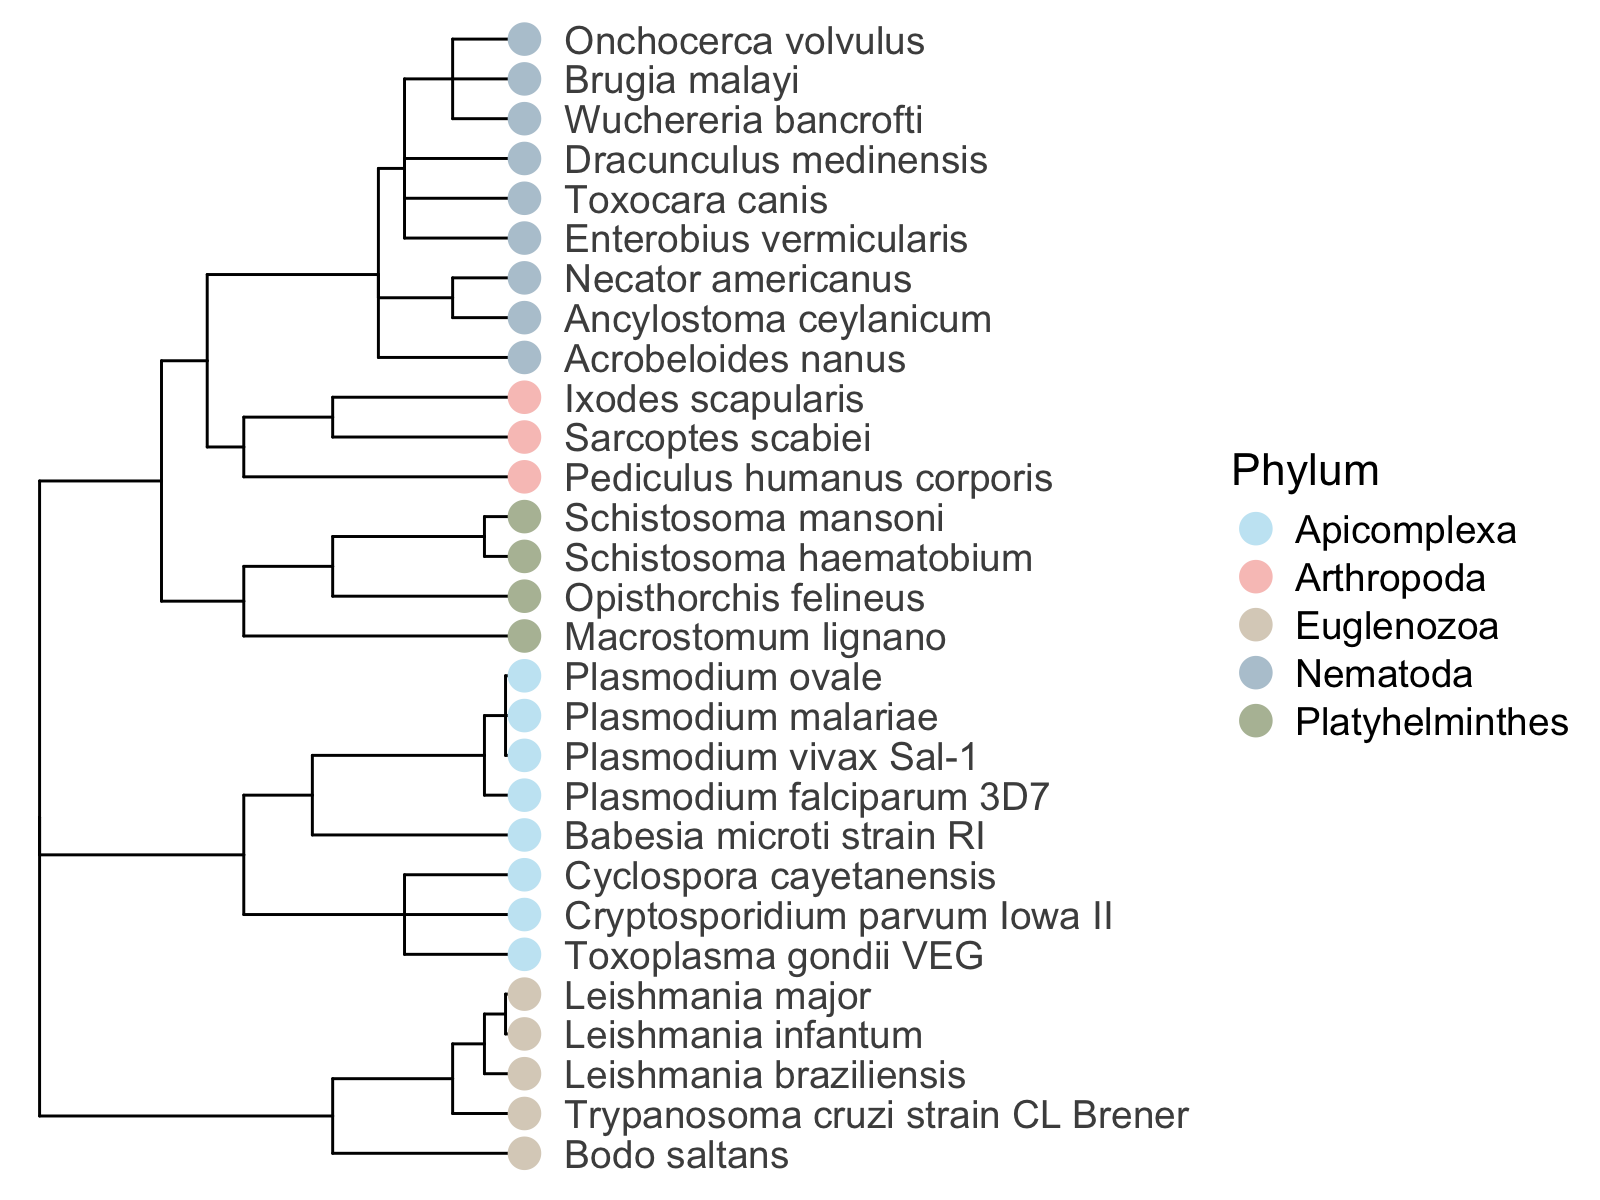

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)

plt <- ggtree(tree_data$phylo) %<+% tip_data +
  geom_tiplab(aes(color = taxonomic_rank), hjust = -0.1, as_ylab = TRUE, size = 14) +
  geom_tippoint(aes(color = taxonomic_rank), size = 5) +
  labs(color = "Phylum") +
  theme(legend.text = element_text(size = 14),
        legend.title = element_text(size = 16)) +
  scale_color_arcadia("secondary")

plt

In [66]:
pdf("plt.pdf")
plt
dev.off()

pdf 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


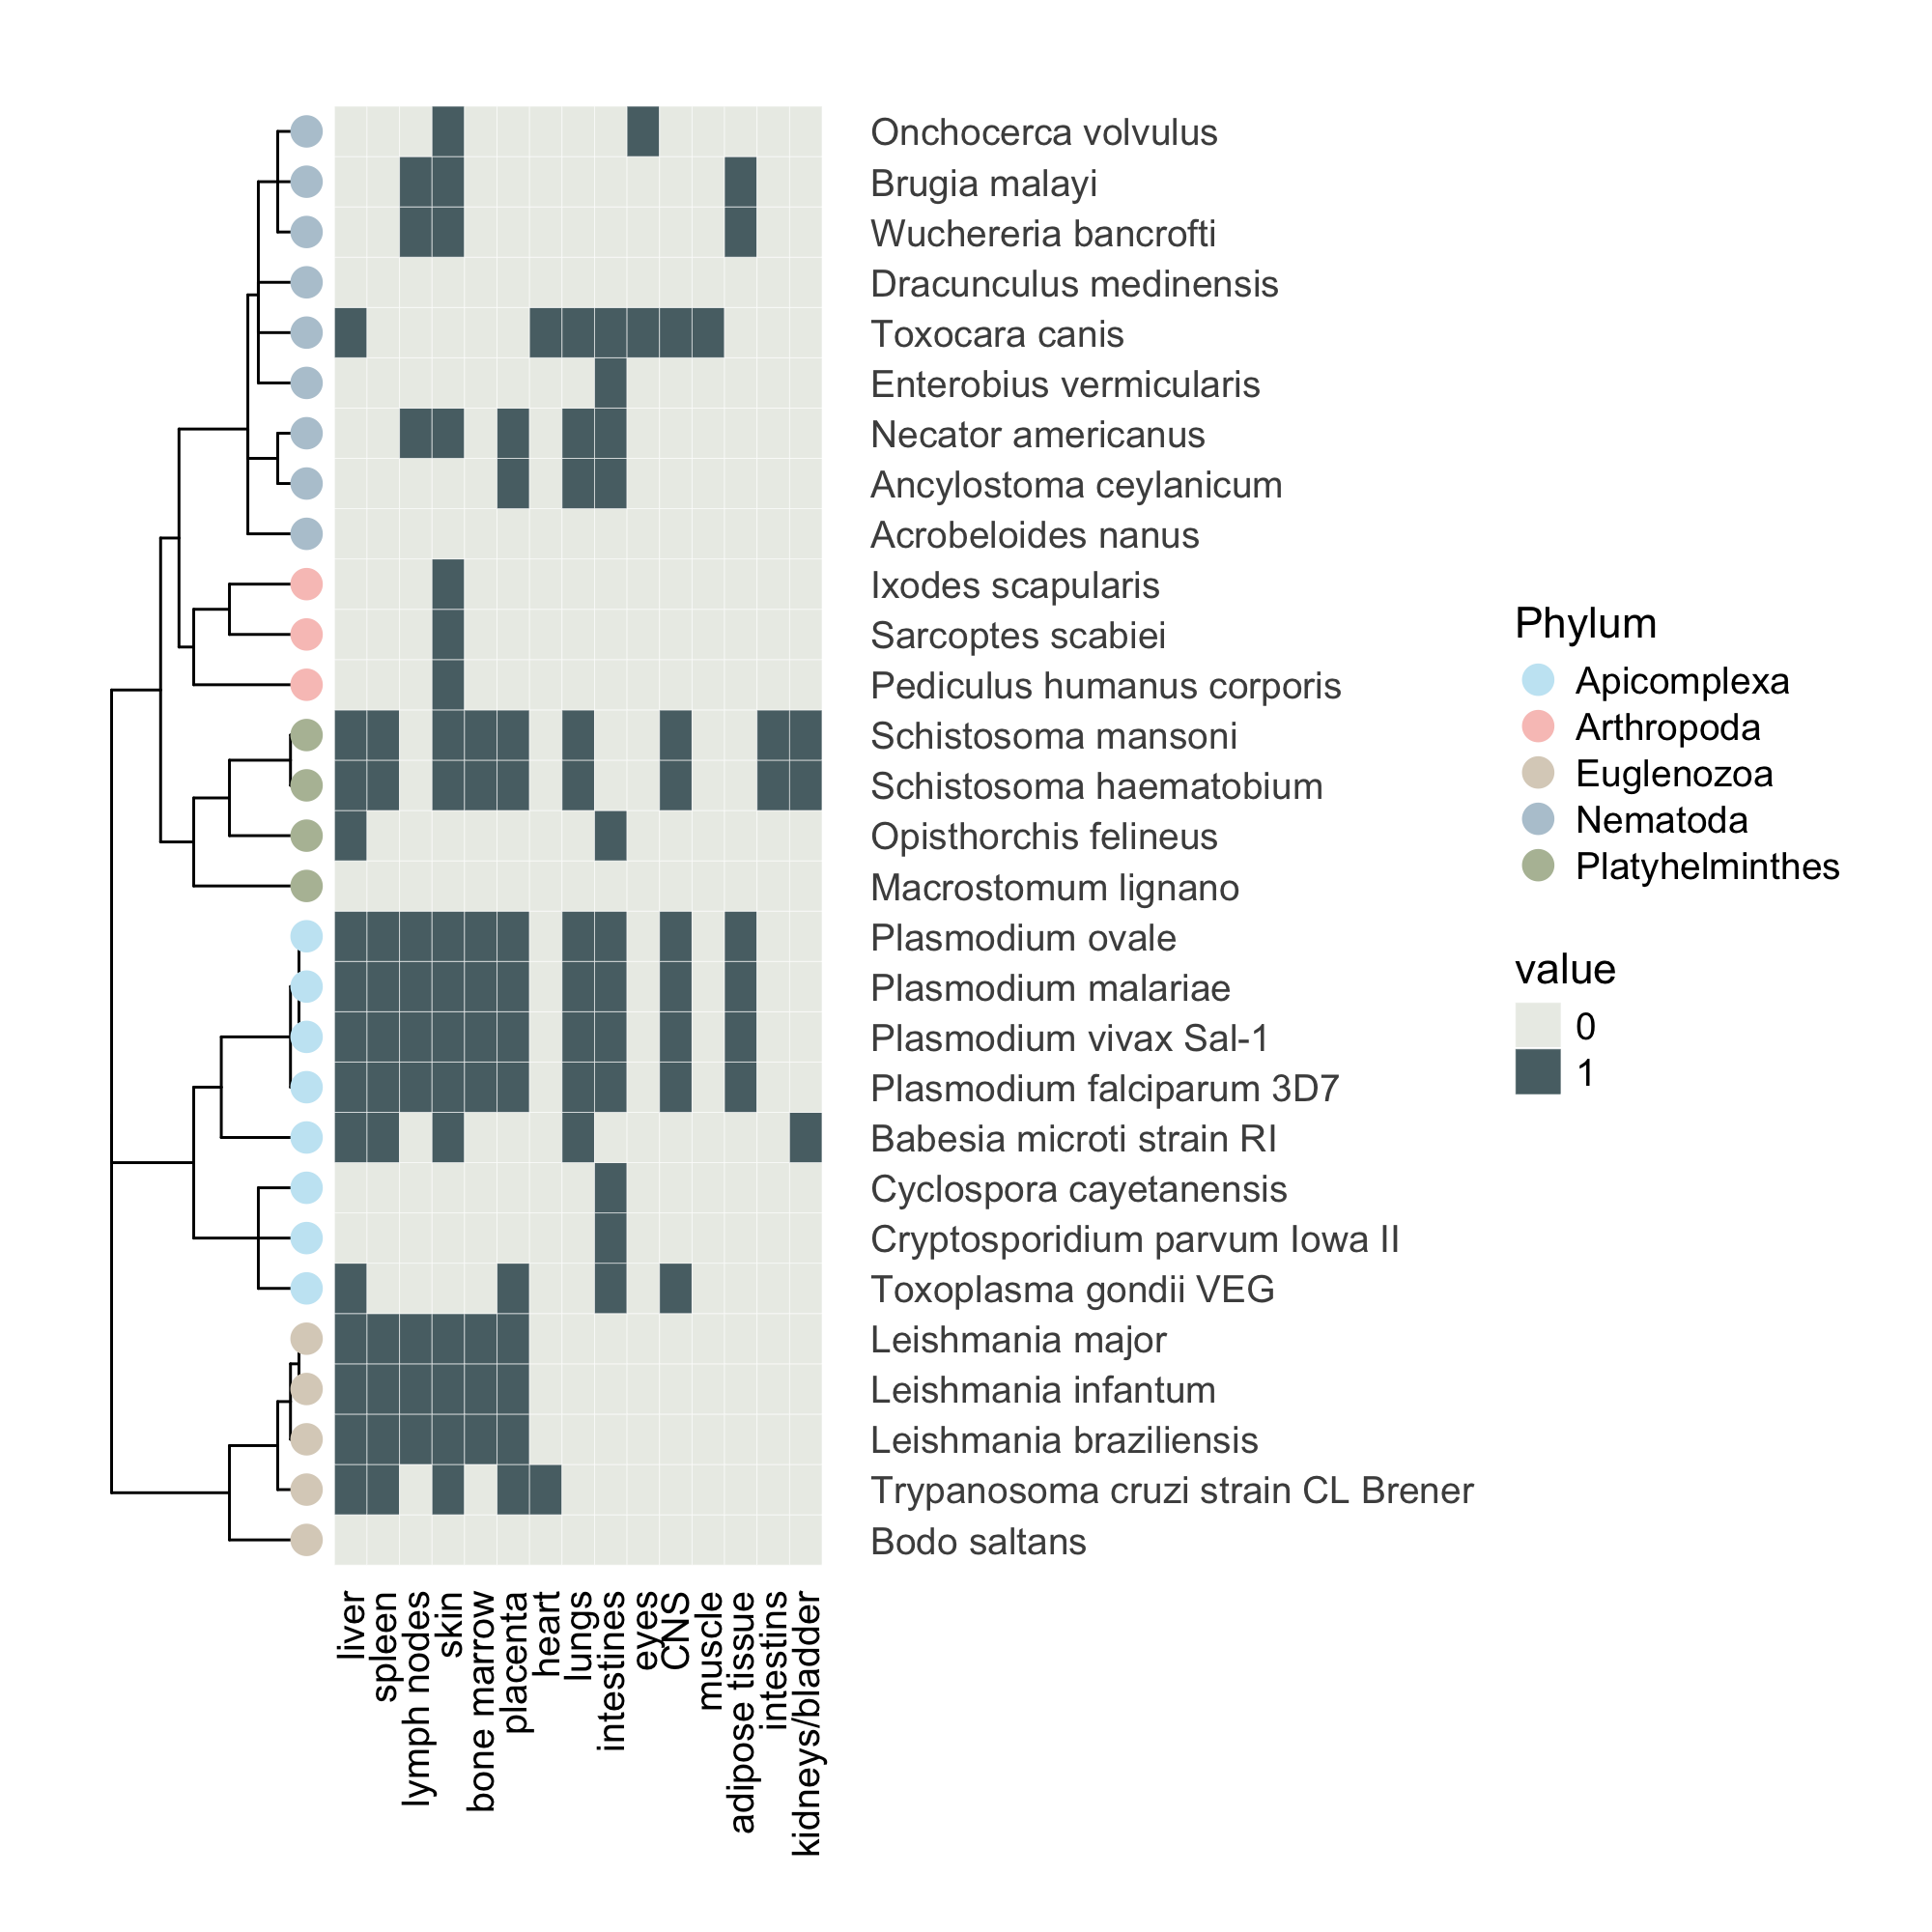

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

plt_heatmap <- gheatmap(plt, heatmap_data, offset = 3, width = 2.5, hjust = 1,
         colnames_angle = 90, colnames_offset_y = 0, font.size = 5) +
  scale_fill_manual(values = c("0" = "#EBEDE8", "1" = "#596F74"), na.value = "grey80") +
  theme(legend.position = "right",
        plot.margin = unit(c(1, 1, 4, 1), "cm")) +
  coord_cartesian(clip = "off") 

plt_heatmap

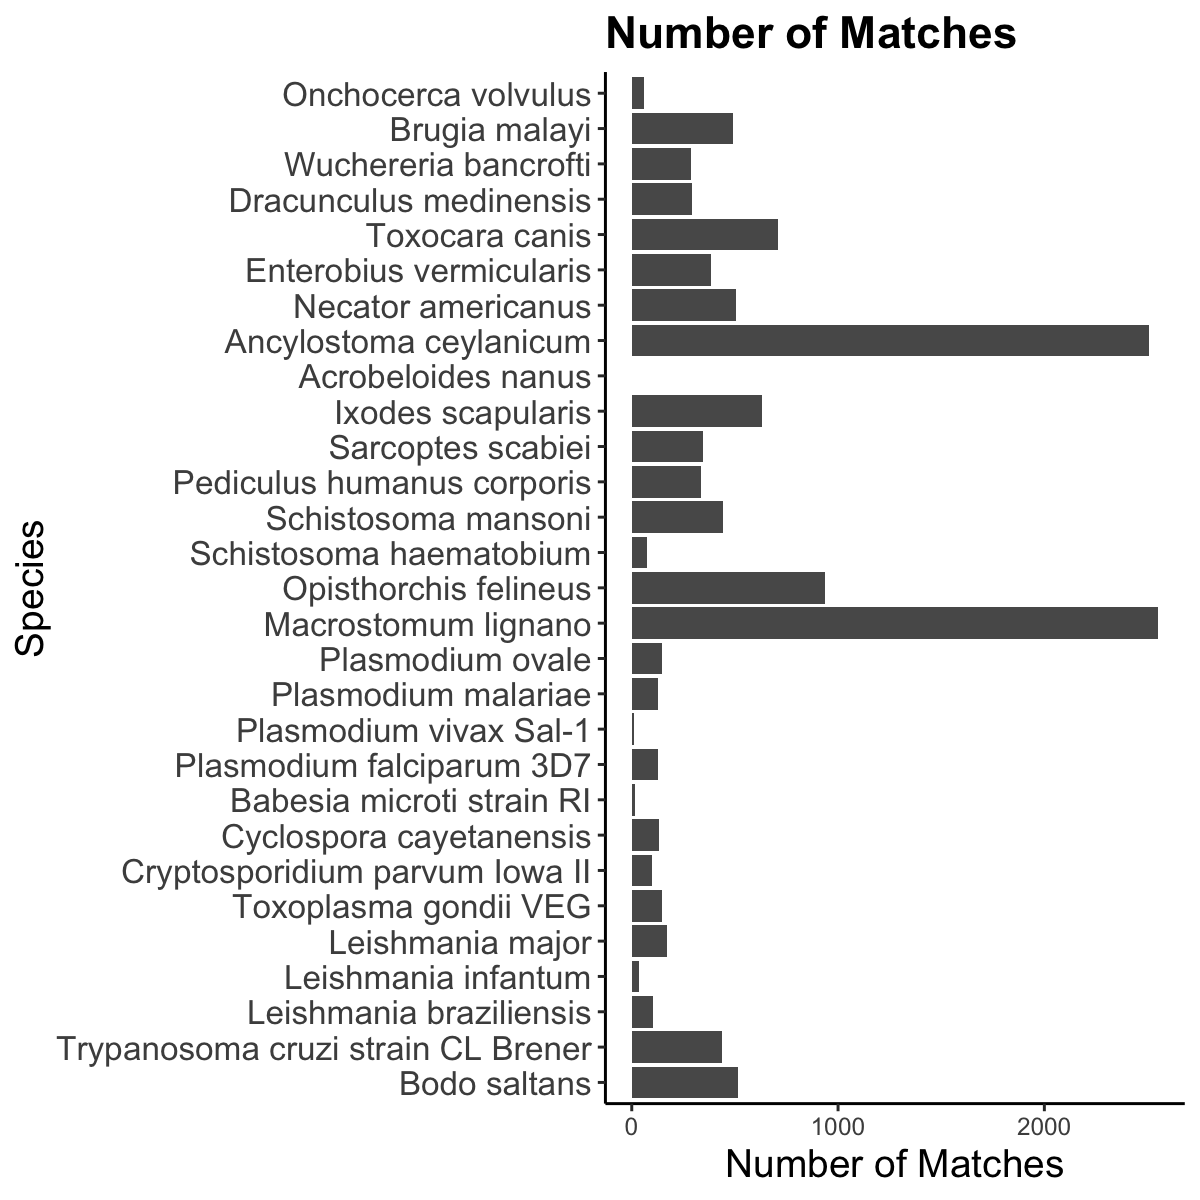

In [68]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200)

species_order <- c(
  "Onchocerca volvulus",
  "Brugia malayi",
  "Wuchereria bancrofti",
  "Dracunculus medinensis",
  "Toxocara canis",
  "Enterobius vermicularis",
  "Necator americanus",
  "Ancylostoma ceylanicum",
  "Acrobeloides nanus",
  "Ixodes scapularis",
  "Sarcoptes scabiei",
  "Pediculus humanus corporis",
  "Schistosoma mansoni",
  "Schistosoma haematobium",
  "Opisthorchis felineus",
  "Macrostomum lignano",
  "Plasmodium ovale",
  "Plasmodium malariae",
  "Plasmodium vivax Sal-1",
  "Plasmodium falciparum 3D7",
  "Babesia microti strain RI",
  "Cyclospora cayetanensis",
  "Cryptosporidium parvum Iowa II",
  "Toxoplasma gondii VEG",
  "Leishmania major",
  "Leishmania infantum",
  "Leishmania braziliensis",
  "Trypanosoma cruzi strain CL Brener",
  "Bodo saltans"
)

tip_data$label <- factor(tip_data$label, levels = rev(species_order))
ggplot(tip_data, aes(x = label, y = num_matches)) +
  geom_col() +
  coord_flip() +
  theme_classic() +
  labs(x = "Species", y = "Number of Matches", title = "Number of Matches") +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    plot.title = element_text(size = 16, face = "bold")
  )

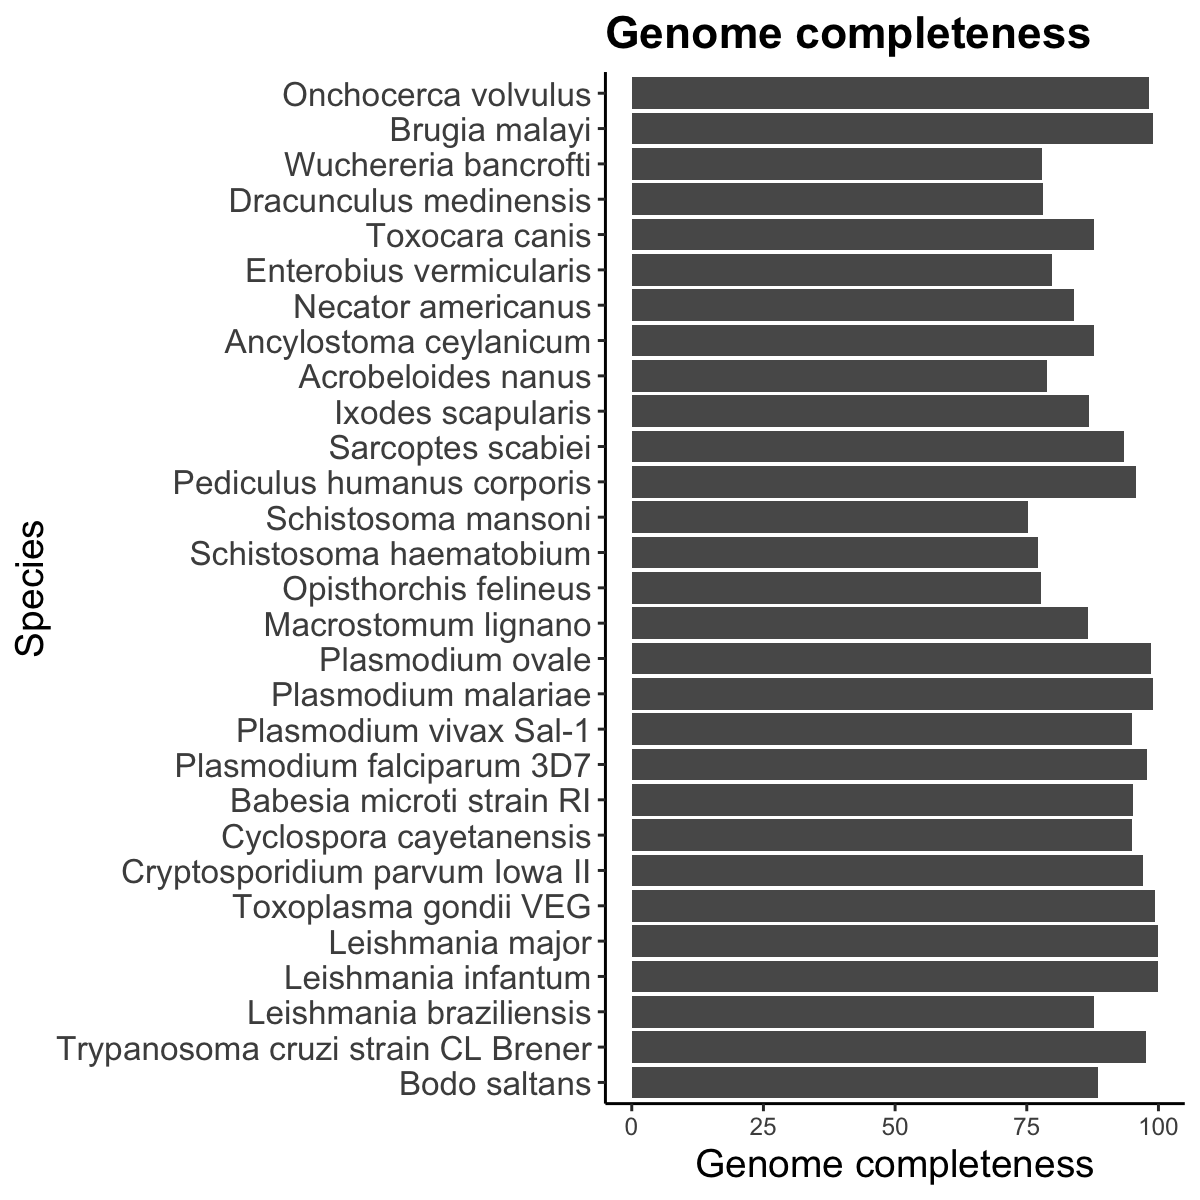

In [71]:
#tip_data$label <- factor(tip_data$label, levels = rev(species_order))
ggplot(tip_data, aes(x = label, y = busco_complete)) +
  geom_col() +
  coord_flip() +
  theme_classic() +
  labs(x = "Species", y = "Genome completeness", title = "Genome completeness") +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    plot.title = element_text(size = 16, face = "bold")
  )

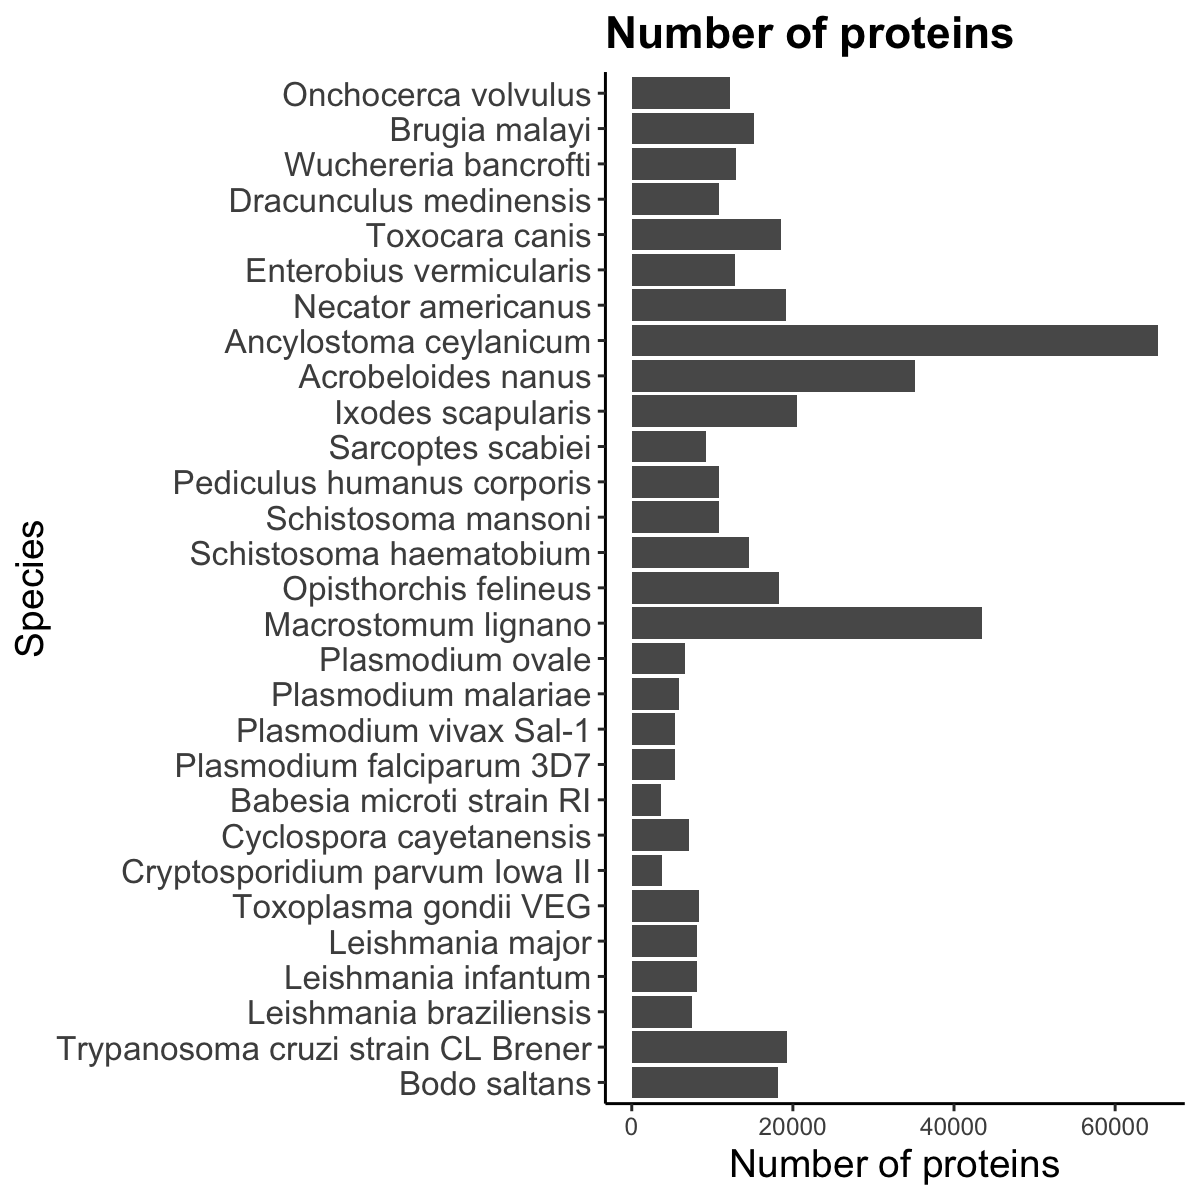

In [72]:
ggplot(tip_data, aes(x = label, y = protein_count)) +
  geom_col() +
  coord_flip() +
  theme_classic() +
  labs(x = "Species", y = "Number of proteins", title = "Number of proteins") +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    plot.title = element_text(size = 16, face = "bold")
  )

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


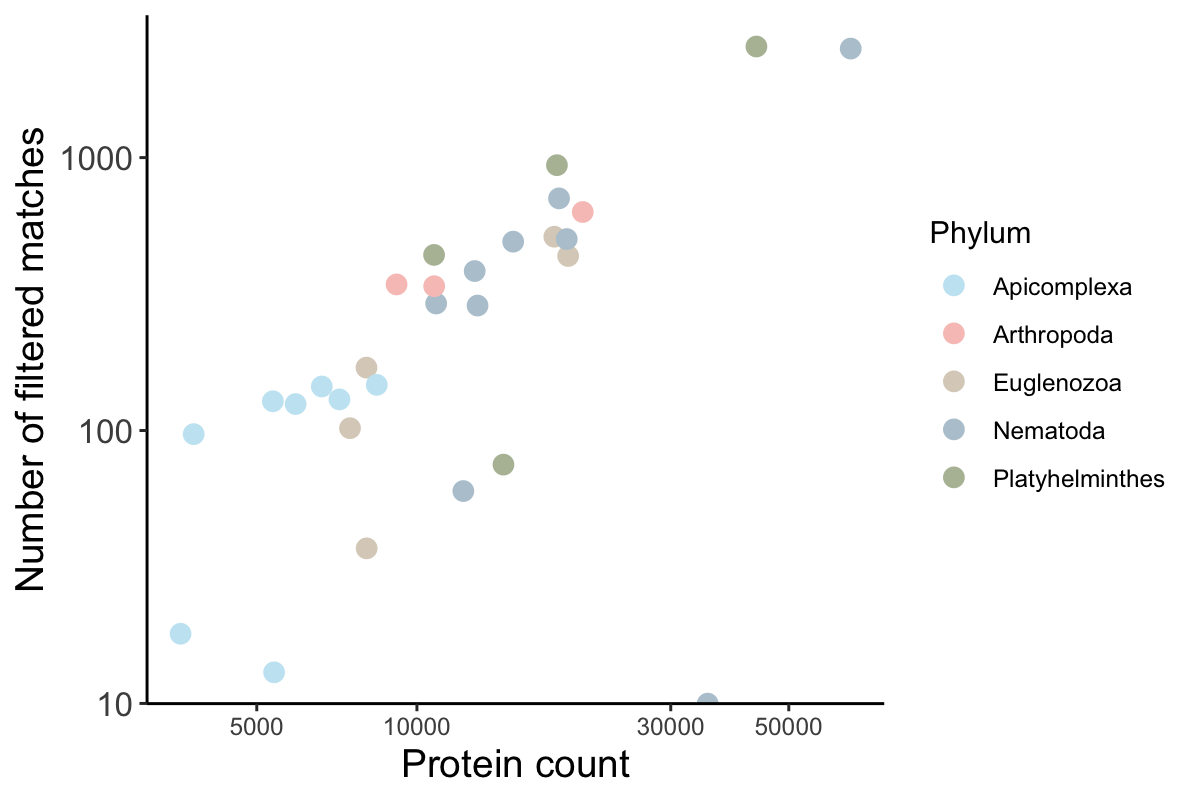

In [82]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)

ggplot(tip_data, aes(x = protein_count, y = num_matches, color = taxonomic_rank)) +
  geom_point(size = 3) +
  theme_classic() +
  labs(x = "Protein count", y = "Number of filtered matches", color = "Phylum") +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    plot.title = element_text(size = 16, face = "bold")
  ) +
    scale_color_arcadia("secondary") +
  scale_y_log10() +
  scale_x_log10()

In [75]:
colnames(tip_data)

[1] "label"                         "organism"                     
 [3] "parasite"                      "parasite_type"                
 [5] "endoparasite_type"             "experimental_design"          
 [7] "note"                          "infects_humans"               
 [9] "average_length_of_infection"   "human_infection_type"         
[11] "definitive_host"               "intermediate_host"            
[13] "typical_human_infection_route" "dpdx"                         
[15] "dpdx link"                     "metadata_checked"             
[17] "parasite_infection_path"       "parasite_infection_tissues"   
[19] "tissue_tropism"                "tissue_tropism_reference"     
[21] "proteome_id"                   "organism_id"                  
[23] "protein_count"                 "busco"                        
[25] "cpd"                           "taxon_mnemonic"               
[27] "taxonomic_lineage"             "components"                   
[29] "genome_assembly_id"            "genome_representation"        
[31] "busco_complete"                "busco_single"                 
[33] "busco_duplicate"               "busco_fragment"               
[35] "busco_missing"                 "busco_n"                      
[37] "num_matches"                   "taxonomic_rank"               
[39] "liver"                         "spleen"                       
[41] "lymph nodes"                   "skin"                         
[43] "bone marrow"                   "placenta"                     
[45] "heart"                         "lungs"                        
[47] "intestines"                    "eyes"                         
[49] "CNS"                           "muscle"                       
[51] "adipose tissue"                "intestins"                    
[53] "kidneys/bladder"

In [62]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggstance_0.3.7      ggnewscale_0.5.0    arcadiathemeR_0.1.0
 [4] ggtree_3.10.0       taxize_0.9.100.1    lubridate_1.9.3    
 [7] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
[10] purrr_1.0.2         readr_2.1.5         tidyr_1.3.1        
[13] tibble_3.2.1        ggplot2_3.5.1       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] tidyselect_1.2.0   IRdisplay_1.1      farver_2.1.2       urltools_1.7.3    
 [5] fastmap_1.1.1      l